<a href="https://colab.research.google.com/github/mostafa-ja/Anomaly-detection/blob/main/Copy_of_autoencoder9_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U sentence-transformers

In [3]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [4]:
import re
import string
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
import pandas as pd
import json
from sklearn.metrics.pairwise import cosine_similarity
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os

# Set seed for PyTorch
torch.manual_seed(42)
# Set seed for NumPy
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# upload HDFS dataset
!wget 'https://zenodo.org/record/3227177/files/HDFS_1.tar.gz'
!tar -xzvf "/content/HDFS_1.tar.gz" -C "/content/"   #unzip the file


--2024-01-04 06:25:51--  https://zenodo.org/record/3227177/files/HDFS_1.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3227177/files/HDFS_1.tar.gz [following]
--2024-01-04 06:25:51--  https://zenodo.org/records/3227177/files/HDFS_1.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 161886385 (154M) [application/octet-stream]
Saving to: ‘HDFS_1.tar.gz’

HDFS_1.tar.gz       100%[===================>] 154.39M   114MB/s    in 1.4s    

2024-01-04 06:25:53 (114 MB/s) - ‘HDFS_1.tar.gz’ saved [161886385/161886385]

HDFS.log
anomaly_label.csv


In [6]:
# count rows of the raw log

with open('/content/HDFS.log', "r") as file:
    totaln=0
    for line in file:
        totaln += 1

print('There are a total of {} lines'.format(totaln))

There are a total of 11175629 lines


In [7]:
def clean(s):
    """ Preprocess log message
    Parameters
    ----------
    s: str, raw log message

    Returns
    -------
    str, preprocessed log message without number tokens and special characters
    """
    # s = re.sub(r'(\d+\.){3}\d+(:\d+)?', " ", s)
    # s = re.sub(r'(\/.*?\.[\S:]+)', ' ', s)
    s = re.sub('\]|\[|\)|\(|\=|\,|\;', ' ', s)
    s = " ".join([word.lower() if word.isupper() else word for word in s.strip().split()])
    s = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', s))
    s = " ".join([word for word in s.split() if not bool(re.search(r'\d', word))])
    trantab = str.maketrans(dict.fromkeys(list(string.punctuation)))
    content = s.translate(trantab)
    s = " ".join([word.lower().strip() for word in content.strip().split()])
    return s

def find_blockid(text):
  match = re.search(r"blk_[-\w]+", text)
  return match.group()


In [8]:
def structured(address):
  with open(address, "r") as file:

      log2index = {}    # give for each unique cleaned log an index
      index2embed = {}  # give for each index(belongs to a unique cleaned log) sentence embedding of that unique cleaned log
      blockId_logs = {} # gather logs(index) which are blong to a specific block id
      index = -1

      for line in file:

        blockId = find_blockid(line)
        if not blockId in blockId_logs:
              blockId_logs[blockId] = []

        cleaned_line = clean(line)

        i = log2index.get(cleaned_line) # i is the index of the cleaned log
        if i is None:
            index += 1
            log2index[cleaned_line] = index
            index2embed[index] = model.encode(cleaned_line)
            blockId_logs[blockId].append(index)
        else :
            blockId_logs[blockId].append(i)


  embeddings = np.array(list(index2embed.values()))
  pca = PCA(n_components=10)
  pca.fit(embeddings)
  reduced_embeddings = pca.transform(embeddings)

  reduced_index2embed = {}
  for i,key in enumerate(index2embed.keys()):
    reduced_index2embed[key]=reduced_embeddings[i]

  return log2index, embeddings, reduced_embeddings, reduced_index2embed, blockId_logs


In [9]:
log2index, embeddings, reduced_embeddings, reduced_index2embed, blockId_logs = structured('/content/HDFS.log')


In [10]:
print('number of templates : ',len(log2index))

number of templates :  52


In [11]:
print('word embedding size(before pca) : ',embeddings[0].shape)
print('word embedding size(after pca) : ',reduced_embeddings[0].shape)

word embedding size(before pca) :  (384,)
word embedding size(after pca) :  (10,)


In [12]:
log2index

{'info dfs data node data xceiver receiving block src dest': 0,
 'info dfs fs namesystem block name systemallocate block': 1,
 'info dfs data node packet responder packet responder for block terminating': 2,
 'info dfs data node packet responder received block of size from': 3,
 'info dfs fs namesystem block name systemadd stored block block map updated is added to size': 4,
 'info dfs data node data xceiver received block src dest of size': 5,
 'info dfs data node data transfer transmitted block to': 6,
 'info dfs data node starting thread to transfer block to': 7,
 'info dfs fs namesystem block ask to replicate to datanode s': 8,
 'info dfs data node data xceiver served block to': 9,
 'info dfs data block scanner verification succeeded for': 10,
 'info dfs data node data xceiver write block received exception javanet socket timeout exception': 11,
 'info dfs data node packet responder packet responder exception javaio eof exception': 12,
 'info dfs data node data xceiver write block 

In [13]:
data_df = pd.DataFrame(list(blockId_logs.items()), columns=['BlockId', 'EventSequence'])
data_df.to_csv("HDFS_sequence.csv",index=None)

In [14]:
data_df.head()

,BlockId,EventSequence
0,blk_-1608999687919862906,"[0, 1, 0, 0, 2, 2, 3, 3, 2, 3, 4, 4, 4, 5, 0, ..."
1,blk_7503483334202473044,"[0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 9, 10,..."
2,blk_-3544583377289625738,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 9, 4, 4, 4, 9, ..."
3,blk_-9073992586687739851,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 10, 10..."
4,blk_7854771516489510256,"[0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 10, 10..."


In [15]:
labels = pd.read_csv('/content/anomaly_label.csv')
labels.head()

,BlockId,Label
0,blk_-1608999687919862906,Normal
1,blk_7503483334202473044,Normal
2,blk_-3544583377289625738,Anomaly
3,blk_-9073992586687739851,Normal
4,blk_7854771516489510256,Normal


In [16]:
# Merge the labels with the data_df DataFrame
data_df = data_df.merge(labels, on='BlockId', how='left')
data_df.head(3)

,BlockId,EventSequence,Label
0,blk_-1608999687919862906,"[0, 1, 0, 0, 2, 2, 3, 3, 2, 3, 4, 4, 4, 5, 0, ...",Normal
1,blk_7503483334202473044,"[0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 9, 10,...",Normal
2,blk_-3544583377289625738,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 9, 4, 4, 4, 9, ...",Anomaly


In [17]:
# Splitting the dataset into train and test
hdfs_sequence_normal = data_df[data_df['Label'] == 'Normal']

hdfs_sequence_abnormal = data_df[data_df['Label'] != 'Normal']

# Print the lengths of train and test datasets
print("Normal Dataset Length:", len(hdfs_sequence_normal))
print("Abnormal Test Dataset Length:", len(hdfs_sequence_abnormal))

Normal Dataset Length: 558223
Abnormal Test Dataset Length: 16838


In [18]:
hdfs_sequence_normal.head(3)

,BlockId,EventSequence,Label
0,blk_-1608999687919862906,"[0, 1, 0, 0, 2, 2, 3, 3, 2, 3, 4, 4, 4, 5, 0, ...",Normal
1,blk_7503483334202473044,"[0, 0, 1, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 9, 10,...",Normal
3,blk_-9073992586687739851,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 10, 10...",Normal


In [19]:
hdfs_sequence_abnormal.head(3)

,BlockId,EventSequence,Label
2,blk_-3544583377289625738,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 9, 4, 4, 4, 9, ...",Anomaly
15,blk_-8531310335568756456,"[0, 1, 0, 0, 2, 3, 2, 3, 2, 3, 4, 4, 4, 10, 10...",Anomaly
23,blk_3947106522258141922,"[0, 0, 1, 0, 2, 3, 2, 3, 4, 4, 2, 3, 4, 10, 10...",Anomaly


In [20]:
# Calculate the split indices based on the desired ratio
total_rows = len(hdfs_sequence_normal)
train_ratio = 0.95
train_rows = int(total_rows * train_ratio)

# Split the DataFrame into training and testing sets
train_hdfs_sequence_normal = hdfs_sequence_normal.iloc[:train_rows]
test_hdfs_sequence_normal = hdfs_sequence_normal.iloc[train_rows:]

print("Normal train Dataset Length:", len(train_hdfs_sequence_normal))
print("Normal Test Dataset Length:", len(test_hdfs_sequence_normal))


Normal train Dataset Length: 530311
Normal Test Dataset Length: 27912


In [21]:
import torch
import torch.nn as nn

class GRUAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sequence_length, dropout_prob):
        super(GRUAutoencoder, self).__init__()
        self.sequence_length = sequence_length
        self.input_dim = input_dim

        # Encoder and Decoder GRU layers
        self.encoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.projection_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        batch_size = x.shape[0]

        # Encoding phase
        _, hidden = self.encoder(x)

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, self.sequence_length, self.input_dim, device=x.device)

        # First input to the decoder is the zero tokens
        input_decoder = torch.zeros(batch_size, 1, self.input_dim, device=x.device)

        for t in range(1, self.sequence_length):
            output, hidden = self.decoder(input_decoder, hidden)
            output = self.projection_layer(output)
            outputs[:, t] = output.squeeze(dim=1)
            # Use actual input as the next input for the decoder (teacher forcing)
            input_decoder = x[:, t:t+1, :]
            #input_decoder = output

        return outputs


In [22]:
reduced_embeddings[0].shape[0]

10

In [23]:
# Define the dimensions
input_dim = reduced_embeddings[0].shape[0]
sequence_length = 5
hidden_dim = 32
dropout_prob = 0.1  # You can adjust this as needed

batch_size = 32

# Generating random input data for demonstration
input_data = torch.randn(batch_size, sequence_length, input_dim).to(device)

# Create the GRU Autoencoder model
model = GRUAutoencoder(input_dim, hidden_dim, sequence_length, dropout_prob).to(device)

# Forward pass through the model
output = model(input_data)

# Check the shape of the output
print("Output shape:", output.shape)


Output shape: torch.Size([32, 5, 10])


In [24]:
# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of Parameters: {num_params}")

Number of Parameters: 8778


In [25]:
name = 'logs_train'
window_size=sequence_length
num_sessions = 0
inputs = []
for log in train_hdfs_sequence_normal['EventSequence']:
   num_sessions += 1
   line = [ reduced_embeddings[int(i)] for i in log]
   for i in range(len(line) - window_size):
      inputs.append(line[i:i + window_size])

print('Number of sessions({}): {}'.format(name, num_sessions))
print('Number of seqs({}): {}'.format(name, len(inputs)))

dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float))

Number of sessions(logs_train): 530311
Number of seqs(logs_train): 7705356


<ipython-input-25-a574d8762b2f>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float))


In [ ]:
batch_size=256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataloader) # regarding to batch size

30100

In [ ]:
for step, (seq) in enumerate(dataloader):
  print(seq[0].shape)
  input = seq[0].view(batch_size, -1)
  print(input.shape)
  break

torch.Size([256, 5, 10])
torch.Size([256, 50])


In [ ]:
def adjust_learning_rate(optimizer, epoch, lr_step=(10,15,20,25), lr_decay_ratio=0.2):
    """Adjust the learning rate based on the epoch number."""
    if epoch == 0:
        optimizer.param_groups[0]['lr'] /= 8
    elif epoch in [1, 2, 3]:  # in step five , we finish warm up ,and start normal learning rate
        optimizer.param_groups[0]['lr'] *= 2
    if epoch in lr_step: # in these steps , we are geting close to optimal point so we need to have shorter step
        optimizer.param_groups[0]['lr'] *= lr_decay_ratio
    return optimizer

In [ ]:
num_epochs = 20
learning_rate = 0.0001

# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))
criterion = nn.MSELoss()

In [ ]:
# Train the model
model.train()
start_time = time.time()
total_step = len(dataloader)
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    optimizer = adjust_learning_rate(optimizer, epoch)
    train_loss = 0
    for step, (seq) in enumerate(dataloader):
        # Forward pass
        seq = seq[0].clone().detach().to(device)
        output = model(seq)
        loss = criterion(output, seq.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch [{}/{}], train_loss: {:.4f}'.format(epoch + 1, num_epochs, train_loss / total_step))
elapsed_time = time.time() - start_time
print('elapsed_time: {:.3f}s'.format(elapsed_time))
print('Finished Training')


Epoch [1/20], train_loss: 0.0071
Epoch [2/20], train_loss: 0.0060
Epoch [3/20], train_loss: 0.0060
Epoch [4/20], train_loss: 0.0060
Epoch [5/20], train_loss: 0.0060
Epoch [6/20], train_loss: 0.0060
Epoch [7/20], train_loss: 0.0060
Epoch [8/20], train_loss: 0.0060


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), '/content/Autoencoder9_parameters.pth')

# **EVALUATION**

In [27]:
my_model = model.load_state_dict(torch.load('/content/Autoencoder9_parameters.pth', map_location=torch.device(device)))

# Put the model in evaluation mode if necessary
model.eval()

GRUAutoencoder(
  (encoder): GRU(10, 32, batch_first=True)
  (decoder): GRU(10, 32, batch_first=True)
  (projection_layer): Linear(in_features=32, out_features=10, bias=True)
)


in cpu
```
my_model = model.load_state_dict(torch.load('model_parameters.pth', map_location=torch.device(device)))

# Put the model in evaluation mode if necessary
model.eval()
```

in cuda


```
model.load_state_dict(torch.load('model_parameters.pth'))

# Put the model in evaluation mode if necessary
model.eval()
```



In [ ]:
reduced_embeddings.shape

(52, 10)

In [ ]:
zero_log = np.array((np.zeros((1,reduced_embeddings[0].shape[0]))))
zero_log

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
reduced_embeddings = np.concatenate((reduced_embeddings, zero_log), axis=0)

In [ ]:
reduced_embeddings[len(reduced_embeddings)-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
reduced_embeddings.shape

(53, 10)

In [162]:
def generate(data):
    window_size = sequence_length
    result = []
    s = 0 #number of logs with less than winow_size length
    for line in data['EventSequence']:
        if (window_size + 1 - len(line)>0):
          s += 1
        line = line + [len(reduced_embeddings)-1] * (window_size + 1 - len(line)) #if the length of the line is less than windows size, it covers by a template with zeros vector
        result.append(line)

    print('Number of sessions: {}'.format(len(result)))
    print('number of logs with less than winow_size length', s)
    return result

In [163]:
test_normal_loader = generate(test_hdfs_sequence_normal)
test_abnormal_loader = generate(hdfs_sequence_abnormal)

Number of sessions: 27912
number of logs with less than winow_size length 0
Number of sessions: 16838
number of logs with less than winow_size length 6181


In [88]:
window_size = sequence_length
criterion = nn.MSELoss()

model.eval()
labels = []
errors = []

start_time = time.time()
with torch.no_grad():
    for loader in [test_normal_loader, test_abnormal_loader]:
        for line in loader:
            max = 0
            for i in range(len(line) - window_size):
                session = line[i:i + window_size]
                seq = [reduced_embeddings[temp] for temp in session]
                seq = torch.tensor(seq, dtype=torch.float).to(device)
                output = model(seq.unsqueeze(0))

                loss = criterion(output, seq)
                if loss > max:
                  max = loss

            if loader is test_normal_loader:
                labels.append(0.)
                errors.append(max.item())
            else:
                labels.append(1.)
                errors.append(max.item())


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5, 10])) that is different to the input size (torch.Size([1, 5, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [89]:
len(errors)

44750

In [90]:
len(labels)

44750

In [95]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({'Error': errors, 'Label': labels})

# Display the DataFrame
print(df)


          Error  Label
0      0.009363    0.0
1      0.009363    0.0
2      0.009363    0.0
3      0.009363    0.0
4      0.009363    0.0
...         ...    ...
44745  0.011235    1.0
44746  0.012016    1.0
44747  0.011110    1.0
44748  0.009363    1.0
44749  0.010721    1.0

[44750 rows x 2 columns]


In [155]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Prepare the data
features = df['Error']
labels = df['Label']

# Choose Threshold Range
thresholds = sorted(set(df['Error']))

best_f1 = 0.0

for threshold in thresholds:
    # Convert error values into binary predictions based on the threshold
    predictions = (features > threshold).astype(int)

    # Calculate F1 score for these predictions compared to the actual labels
    f1 = f1_score(labels, predictions)

    # Check if this threshold gives a better F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold for Max F1 Score: {best_threshold} | Best F1 Score: {best_f1}")

# 'best_threshold' is obtained from previous code
predictions = (features > best_threshold).astype(int)

precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
accuracy = accuracy_score(labels, predictions)

print(f"Precision: {precision} | Recall: {recall} | Accuracy: {accuracy}")

Best Threshold for Max F1 Score: 0.009748406708240509 | Best F1 Score: 0.9942812890927503
Precision: 0.9973111854684512 | Recall: 0.9912697470008315 | Accuracy: 0.9957094972067039


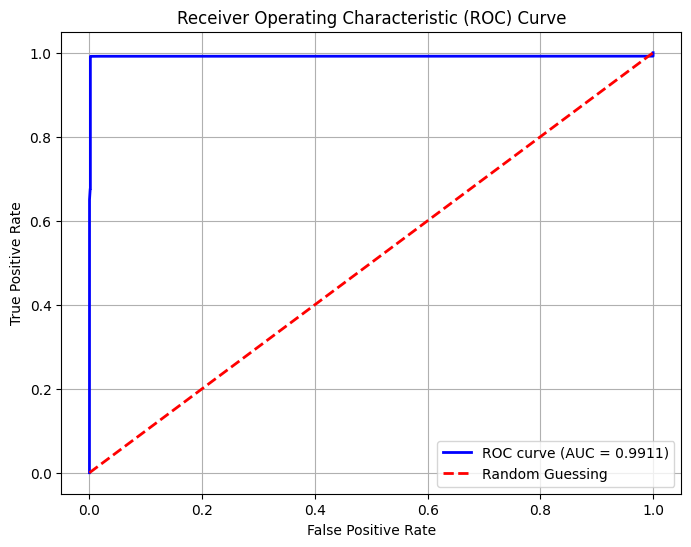

In [152]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the data
X = df['Error']  # Features
y = df['Label']  # Target labels

# Compute fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y, X)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [28]:
batch_size=1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataloader) # regarding to batch size

7705356

In [31]:
for i in dataloader:
  print(len(i))
  break

1


In [34]:
i[0].shape

torch.Size([1, 5, 10])

In [ ]:
window_size = sequence_length
criterion = nn.MSELoss()

model.eval()
errors = []

start_time = time.time()
with torch.no_grad():
  for line in dataloader:
      output = model(line[0])

      loss = criterion(output, line[0])
      errors.append(loss.item())



In [ ]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame({'Error': errors})

# Display the DataFrame
print(df)


In [ ]:
df[df['Error']>0.009748406708240509]